# Importing Important Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error , r2_score

plt.style.use('bmh')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


# Input Data and its Description

In [2]:
data_train = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv', index_col='date', parse_dates=['date'])
data_test = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv', index_col='date', parse_dates=['date'])

Date of format YYYY-MM-DD.

Mean temperature averaged out from multiple 3 hour intervals in a day.

Humidity value for the day (units are grams of water vapor per cubic meter volume of air).

Wind speed measured in kmph.

Pressure reading of weather (measure in atm)***mb

In [3]:
print(data_train.info())
print('*****************')
print(data_test.info())
print('=================================================')
print(data_train.describe())
print('*****************')
print(data_test.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB
None
*****************
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB
None
          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     2

### Renaming Columns

In [4]:
data_train.rename(columns = {'meantemp':'temp'} , inplace = True)
data_test.rename( columns =  {'meantemp':'temp'} , inplace = True)
data_train.rename(columns = {'meanpressure':'pressure'} , inplace = True)
data_test.rename( columns =  {'meanpressure':'pressure'} , inplace = True)

### Checking for any Missing Values, Total Number of Unique Values and Datatype of Every Column/Feature

In [5]:
df_info = pd.concat([data_train.isna().sum() , data_train.nunique() , data_train.dtypes] , axis = 1)
df_info.columns = ['missing' , 'n unique' , 'dtype']
df_info

,missing,n unique,dtype
temp,0,617,float64
humidity,0,897,float64
wind_speed,0,730,float64
pressure,0,626,float64


There is No Missing (null/na) Values and No Categorical Values.

# Data Analysis and Pre-Processing

### Making a Copy of DataFrame to work upon.

In [6]:
df_train = data_train.copy()

In [7]:
# df_train['date'] = pd.to_datetime(df_train['date'])

In [8]:
# df_train.set_index('date', inplace=True)

### Visualization of Data with Plots

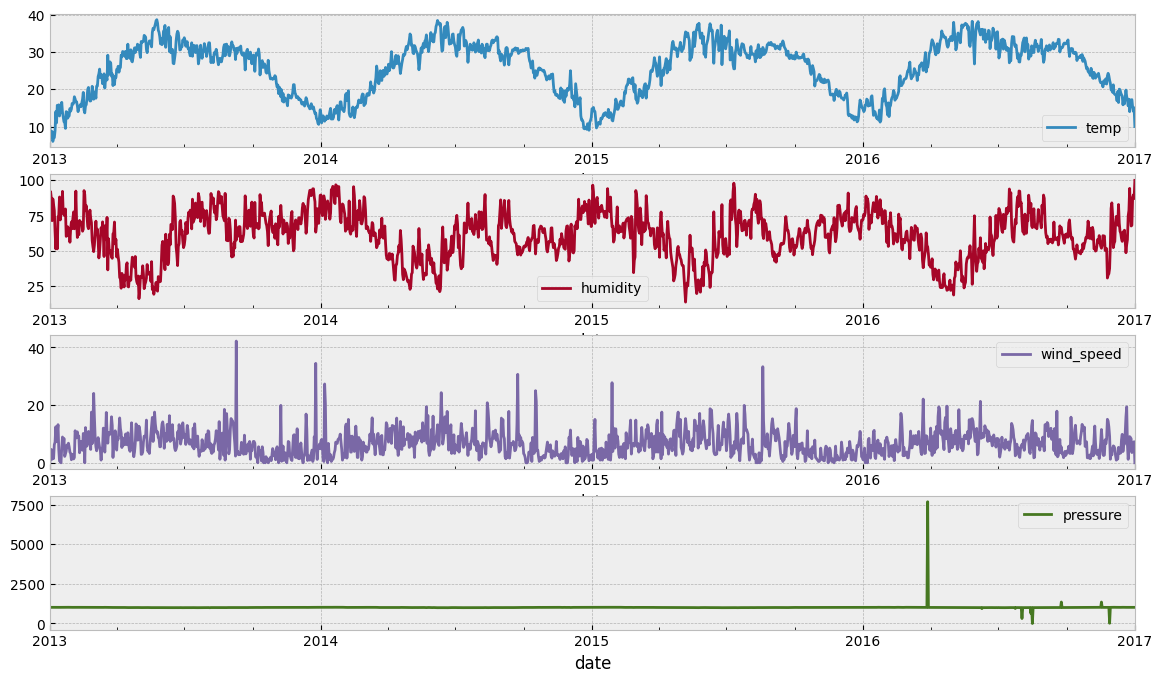

In [9]:
df_train.plot(subplots = True , layout = (4,1) , figsize = (14,8) , sharex= False)
plt.show()

### Cleaning of Pressure Data with Central Tendency Imputation

We can see a sudden noise in Pressure data.

In [10]:
df_train['pressure'].describe()

count    1462.000000
mean     1011.104548
std       180.231668
min        -3.041667
25%      1001.580357
50%      1008.563492
75%      1014.944901
max      7679.333333
Name: pressure, dtype: float64

According to Google, Lowest Recorded Pressure in the World ever Recorded is 870 mb in Pacific Ocean¶
and Highest is 1083 mb in Siberia, Russia.

So Values greater than 1083 (e.g. 7679) is Not Possible and Values Less than 870 is also Not Possible.

Moreover, Negative Value like (-3.041667) is also Not Possible.

In [11]:
df_errors = df_train[ (df_train['pressure'] < 900) | (df_train['pressure'] >1083) ]
df_errors

,temp,humidity,wind_speed,pressure
date,,,,
2016-03-28,25.933333,52.800000,6.546667,7679.333333
2016-08-02,30.687500,72.125000,6.375000,310.437500
2016-08-14,28.933333,83.700000,6.370000,633.900000
2016-08-16,31.333333,66.416667,14.666667,-3.041667
2016-09-24,31.240000,66.480000,5.496154,1352.615385
2016-11-17,21.730769,51.730769,11.550000,1350.296296
2016-11-28,22.454545,37.318182,9.185714,12.045455


Since this is a Time Series data, we can just drop the Noise/null values/Incorrect data as it will cause a Break in Graph. So we will drop the Error Entries and fill the Empty Spaces with the help of Central Tendency Imputation (mean).

In [12]:
df_cleaned = df_train.drop(df_errors.index , axis = 0)                # dataframe with no errors
mean_pressure_modified = df_cleaned['pressure'].mean()                # mean of cleaned dataframe
df_train.loc[df_errors.index , 'pressure'] = mean_pressure_modified   # impute with error pressure

array([[<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>]], dtype=object)

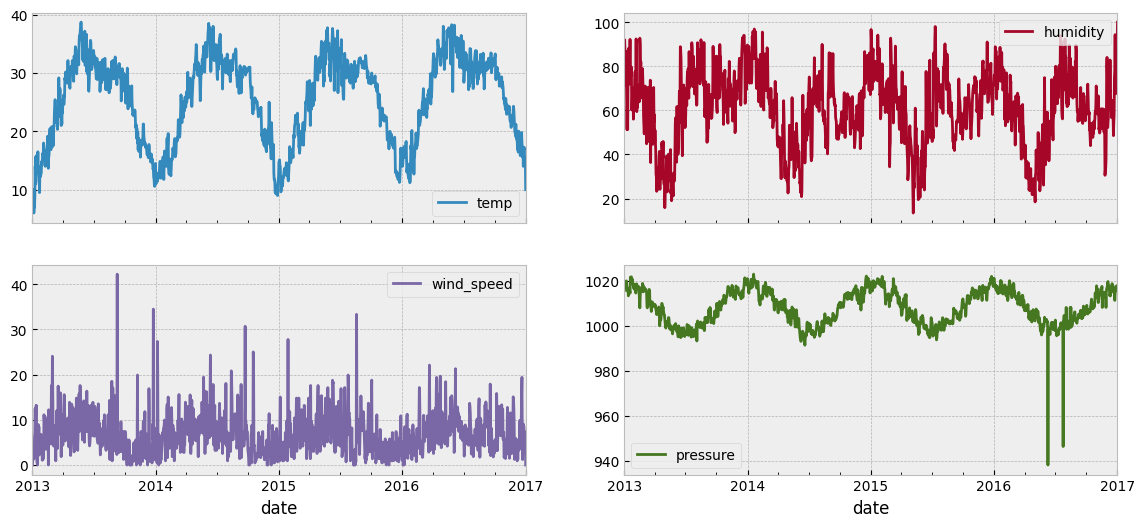

In [13]:
df_train.plot(subplots = True , layout = (2,2) , figsize = (14,6))

In [14]:
df_train['pressure'].describe()

count    1462.000000
mean     1008.178187
std         7.808525
min       938.066667
25%      1001.625000
50%      1008.500000
75%      1014.875000
max      1023.000000
Name: pressure, dtype: float64

Text(0.5, 1.0, 'Pressure after Cleaning')

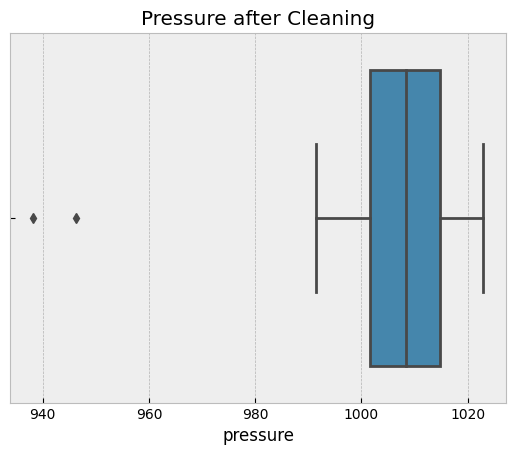

In [15]:
sns.boxplot(df_train , x = 'pressure')
plt.title('Pressure after Cleaning')

We can see that there are still some Outliers.

### Weekly and Monthly Data for better Visualization

Here, we are creating Weakly and Monthly Time Frames.

In [16]:
df_weekly = df_train.resample('W').mean()
df_monthly = df_train.resample('ME').mean()

To Reduce Noise and make it Smoother we draw Weekly Data.

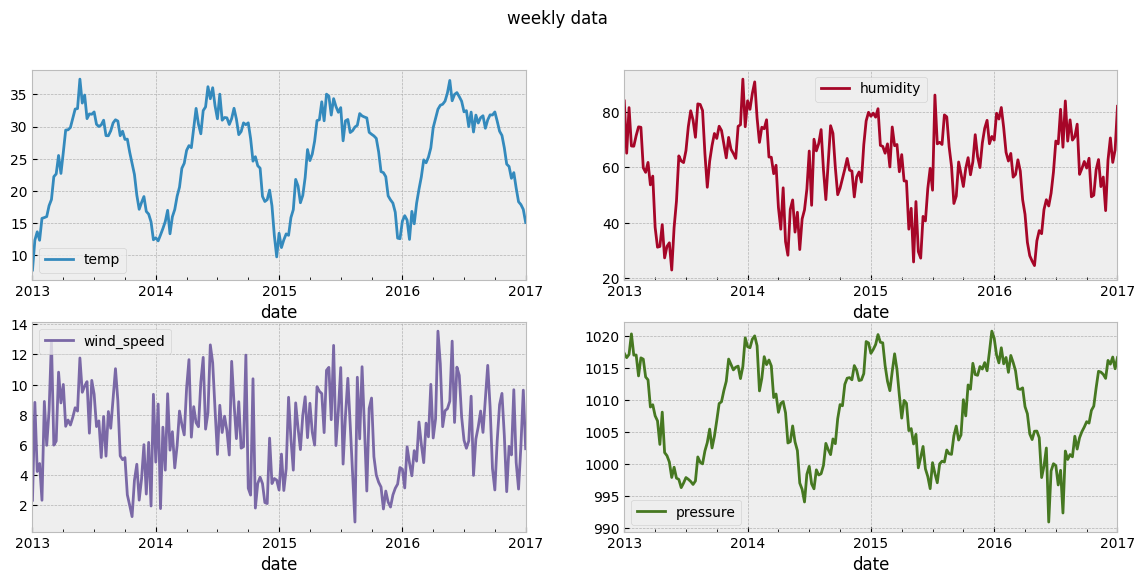

In [17]:
df_weekly.plot(subplots = True , layout = (2,2) , 
                figsize = (14,6) , title = 'weekly data' , sharex=False)
plt.show()

### Smoothness with Moving/Rolling Window over 28 Weeks

In [18]:
MA28 = df_weekly.rolling(window=28).mean()

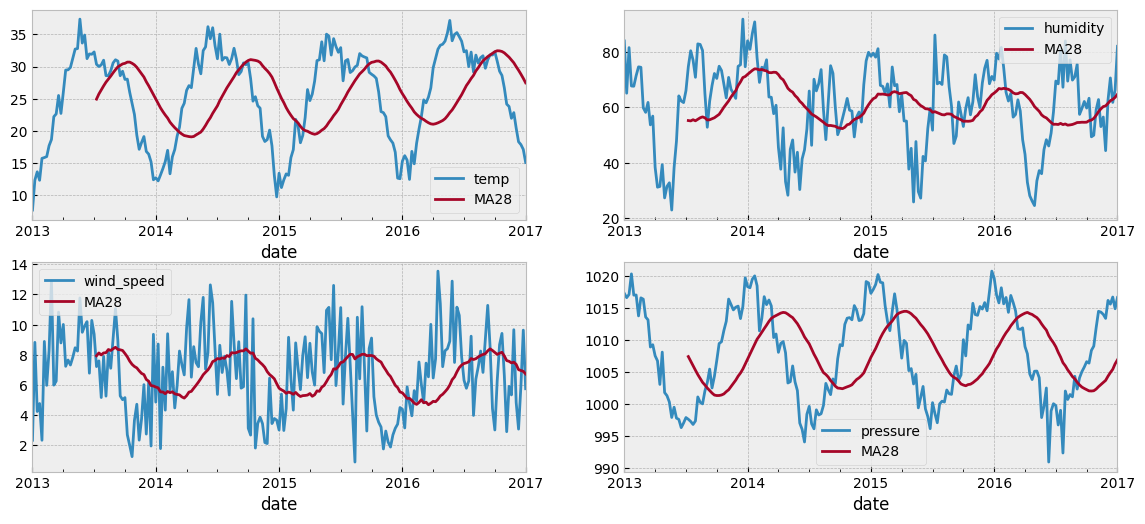

In [19]:
fig , ax = plt.subplots(nrows = 2 , ncols=2 ,figsize = (14,6))
for ax , col in zip(ax.flat , df_train.columns):
    df_weekly[col].plot(ax = ax , legend = col)
    MA28[col].plot(ax = ax  , label = 'MA28')
    ax.legend()

### Correlation

(<Axes: title={'center': 'Correlation'}>, Text(0.5, 1.0, 'Correlation'))

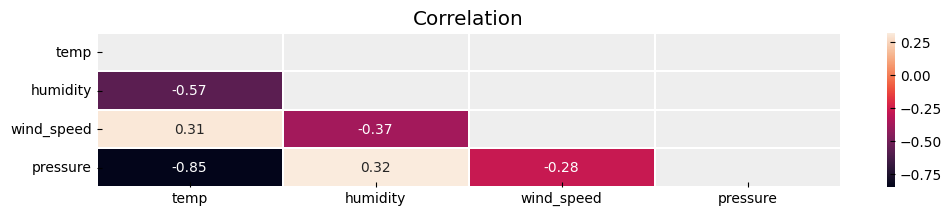

In [20]:
df_corr = df_train.corr()
mask = np.tril( np.ones(df_corr.shape) , k = -1).astype(bool)
df_corr = df_corr.where(mask)

plt.figure(figsize = (12,2)) , plt.grid()
sns.heatmap(df_corr , annot =True ,linewidths=0.1) , plt.title('Correlation')

In [21]:
# sns.pairplot(df_train)
# plt.show()

### Monthly Average of Temperature over the Years

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

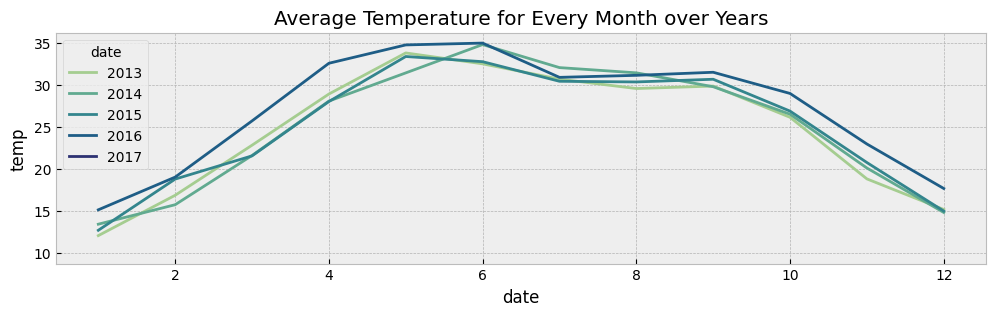

In [22]:
plt.figure(figsize = (12,3))
sns.lineplot(df_train ,x = df_train.index.month ,y = 'temp' , hue = df_train.index.year , 
             palette='crest' , errorbar = None)
plt.title('Average Temperature for Every Month over Years')
plt.show()

### Seasonality

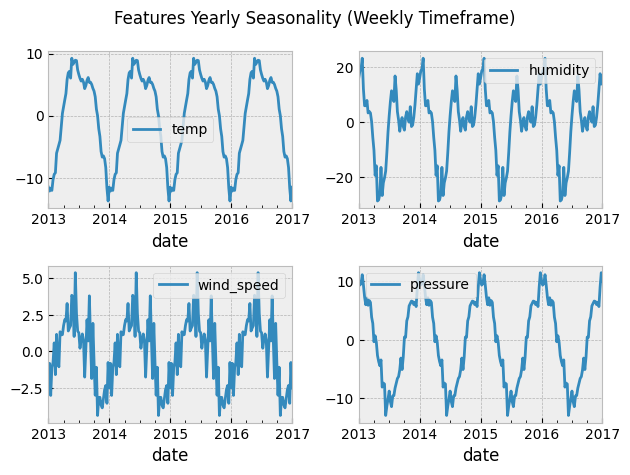

In [23]:
fig, ax = plt.subplots(2,2)
for ax, col in zip(ax.flat, df_train.columns):
    decompose= sm.tsa.seasonal_decompose(df_weekly[col])
    decompose.seasonal.plot(ax = ax, label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('Features Yearly Seasonality (Weekly Timeframe)')

It is Visible that there is Seasonality for every Feature but 'wind_speed' has More Distortion/Noise.

We need to take Smaller Observation Period,(6 months), because for Complete Data, we can not Visualize Daily Timeframe.

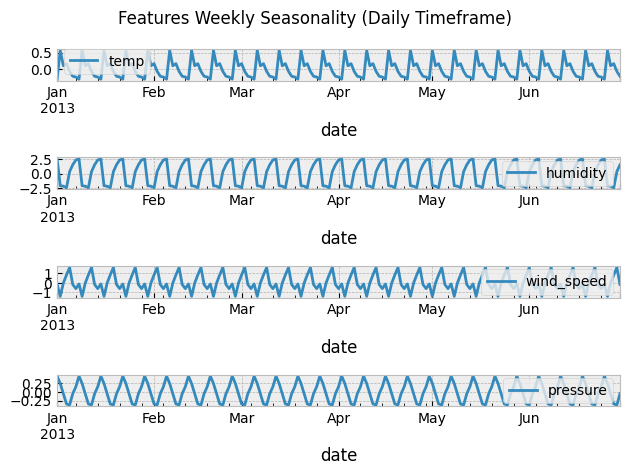

In [24]:
period = slice( '2013-01' ,'2013-06' )   # 6 month
fig, ax = plt.subplots(4,1)
for ax, col in zip(ax.flat, df_train.columns):
    decompose= sm.tsa.seasonal_decompose(df_train[period][col])
    decompose.seasonal.plot(ax = ax, label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('Features Weekly Seasonality (Daily Timeframe)')

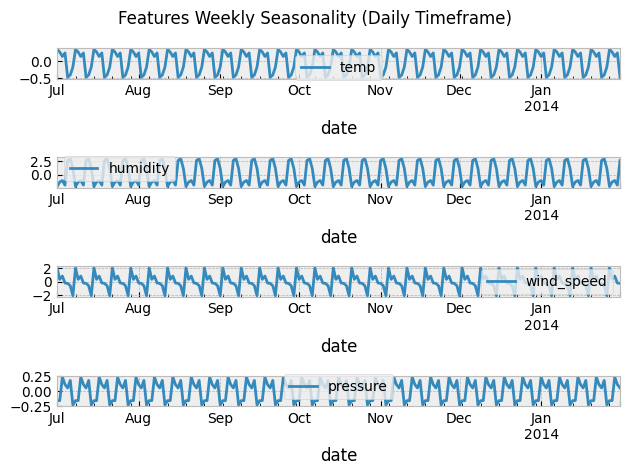

In [25]:
period = slice( '2013-07' ,'2014-01' )   # Next 6 month
fig, ax = plt.subplots(4,1)
for ax, col in zip(ax.flat, df_train.columns):
    decompose= sm.tsa.seasonal_decompose(df_train[period][col])
    decompose.seasonal.plot(ax = ax, label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('Features Weekly Seasonality (Daily Timeframe)')

### Trend

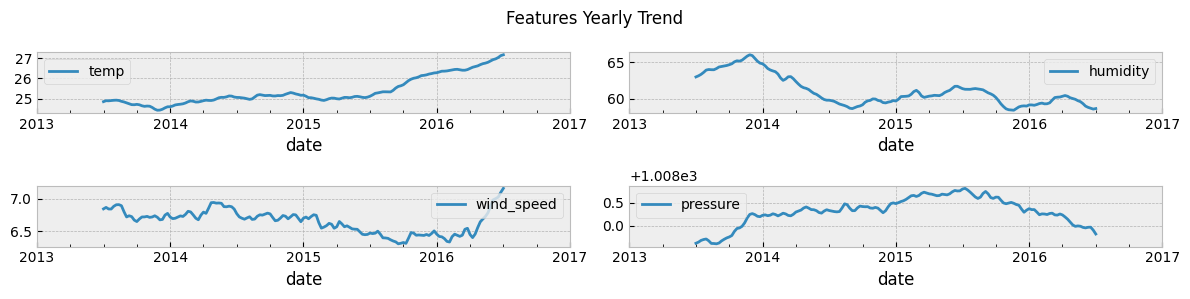

In [26]:
fig, ax = plt.subplots(2,2 , figsize = (12,3))
for ax, col in zip(ax.flat, df_train.columns):
    decompose= sm.tsa.seasonal_decompose(df_weekly[col])
    decompose.trend.plot(ax = ax, label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('Features Yearly Trend')

# Metrics for Evaluation

### Metric Function

In [27]:
def metrics(y_true, y_pred, model):
    mae = mean_absolute_error(y_true, y_pred )
    mape = mean_absolute_percentage_error(y_true, y_pred )
    r2 = r2_score(y_true, y_pred )
    
    metric_dict = {
        'model':model ,
        'mae': f'{mae:0.2f}',
        'mape':f'{100*mape:0.2f}%',
        'r2': f'{100*r2:0.2f}%'
    }
    return metric_dict

An Empty List to Add Metric Scores for Final Comparison of Models at End

Metric Dictionary will Append to this List

In [28]:
model_performance = []

# Different Models Training/Application and Predictions

In [29]:
df_all = pd.concat([df_train, data_test])

In [30]:
duplicated_index = df_all[df_all.index.duplicated()]
df_all = df_all[~df_all.index.duplicated(keep='last')]

## Naïve Forecasting

We are considering that there is an Yearly Seasonality.

In [31]:
diff_1y = df_all['temp'].diff(365)
mean_abs_err = diff_1y.abs().mean()
print(f'Mean Absolute Error for Naïve Forecasting Period of 1 Week = {mean_abs_err:0.2f}')

Mean Absolute Error for Naïve Forecasting Period of 1 Week = 2.56


### Metric Evaluation

In [32]:
df_naive = df_all.shift(365)
score_naive = metrics(df_all['temp'][365:] , df_naive['temp'][365:] , 'Naive')
score_naive

{'model': 'Naive', 'mae': '2.56', 'mape': '11.12%', 'r2': '80.45%'}

Saving the Model Performance to Compare with others

In [33]:
model_performance.append(score_naive)

### Visualization and Plotting of Predicted v/s Real

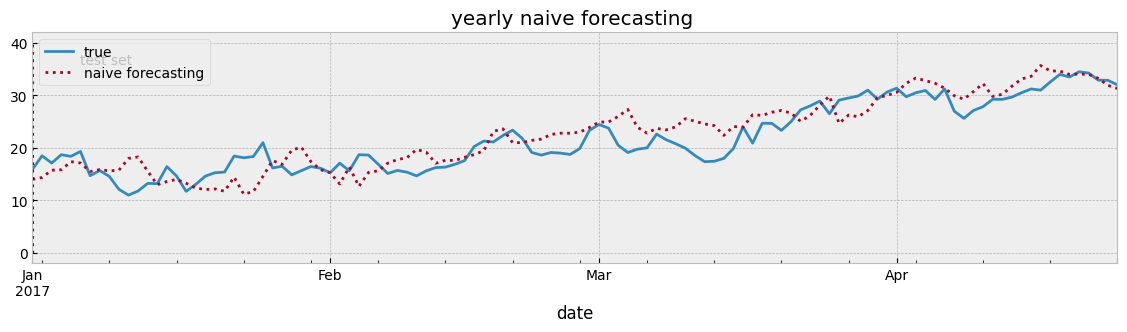

In [34]:
df_all['2017':]['temp'].plot(label = 'true' , figsize = (14,3))
df_naive['2017':]['temp'].plot(label = 'naive forecasting' , style = ':')
plt.vlines(x = '2017-01-01' , ymin = 0 , ymax = 40 , linestyles= ':' , colors='k')
plt.annotate(text = 'test set' , xy = ('2017-01-06' , 36))  # annotation coordinant 
plt.title('yearly naive forecasting ') 
plt.legend()
plt.show()

## Deep Learning - RNN

We will be using Multivariate Model i.e. use all Features (Temperature, Humidity, Pressure, Wind_Speed) to Predict one variable: "Temperature"

### Splitting of Data into Training and Validation Set

In [35]:
train = df_train[:'2016-05']
validation = df_train['2016-06':]    # almost 15% of train data set as validation set
test = data_test.copy()
train.shape, validation.shape , test.shape

((1247, 4), (215, 4), (114, 4))

### Scaling of Data

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

dfs_train = scaler.fit_transform(train)
dfs_val = scaler.transform(validation)   # validation and test set do not need to fit, they just need transform
dfs_test = scaler.transform(test)

### Function to Convert Data to Sequential Form

In [37]:
def make_sequence(df, sequence_length):
    X = [] 
    target = []
    for i in range(len(df) - sequence_length):
        s = df[i : i + sequence_length]
        t = df[i+sequence_length , 0]  # temp 
        X.append(s)
        target.append(t)
    return np.array(X) , np.array(target)

### Function to Inverse Transform Predictions and True Values

In [38]:
def inverse_transform(y_true, y_pred, scaler):
    # Create a dummy array with the same number of columns as the original dataset
    dummy_pred = np.zeros((len(y_pred), scaler.n_features_in_))  # Same shape as transformed features
    dummy_true = np.zeros((len(y_true), scaler.n_features_in_))  # Same shape as transformed features
    
    # Assign the predicted and true values to the first column (target feature)
    dummy_pred[:, 0] = y_pred[:, 0]
    dummy_true[:, 0] = y_true
    
    # Inverse transform both predicted and true values
    y_pred_original = scaler.inverse_transform(dummy_pred)[:, 0]
    y_true_original = scaler.inverse_transform(dummy_true)[:, 0]
  
    return  y_true_original, y_pred_original 

In [39]:
seq = 28
ds_train , target_train = make_sequence(dfs_train, sequence_length=seq)
ds_val , target_val = make_sequence(dfs_val ,sequence_length=seq)
ds_test , target_test = make_sequence(dfs_test, sequence_length=seq)
ds_train.shape , ds_val.shape , ds_test.shape

((1219, 28, 4), (187, 28, 4), (86, 28, 4))

In [40]:
import tensorflow as tf
tf.random.set_seed(42)
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (seq , ds_train.shape[2])) ,
    tf.keras.layers.SimpleRNN(32 , activation = 'sigmoid'),
    tf.keras.layers.Dense(1)
])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss' , 
                                                  patience=10 , restore_best_weights=True)
model_rnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02) , 
              loss = tf.keras.losses.MeanSquaredError() , 
              metrics = ['mae'])
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model_rnn.fit(x = ds_train,y = target_train , validation_data=(ds_val , target_val),
                        epochs=100 , batch_size = 32 , callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1731610681.594071      69 service.cc:145] XLA service 0x7efd20005150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731610681.594149      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


29/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5960 - mae: 0.6037

I0000 00:00:1731610682.352640      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.5118 - mae: 0.5471 - val_loss: 0.0666 - val_mae: 0.1882
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0691 - mae: 0.2059 - val_loss: 0.0524 - val_mae: 0.1746
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0562 - mae: 0.1806 - val_loss: 0.0444 - val_mae: 0.1629
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0504 - mae: 0.1691 - val_loss: 0.0401 - val_mae: 0.1526
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0475 - mae: 0.1644 - val_loss: 0.0407 - val_mae: 0.1520
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0461 - mae: 0.1625 - val_loss: 0.0416 - val_mae: 0.1545
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0454 - mae: 0.1615 - val_loss: 0.0432 - val_mae: 0.1579
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0453 - mae: 0.1615 - val_loss: 0.0447 - val_mae: 0.1611
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0453 - mae: 0.

Model isn't Overfitted or Underfitted, it reaches Minimum Local after 13 epochs.(Early Stopping)

In [42]:
val_loss , val_mae = model_rnn.evaluate(ds_val , target_val)
print(f'validation loss : {val_loss:0.2f} ')
print(f'validation mean absolute error : {(val_mae):0.3f} ')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467 - mae: 0.1654 
validation loss : 0.04 
validation mean absolute error : 0.153 


### Metric Evaluation

Metric on Validation Set

In [43]:
y_pred = model_rnn.predict(ds_val)
y_true_original_rnn , y_pred_original_rnn= inverse_transform(target_val, y_pred , scaler )
metrics(y_true_original_rnn , y_pred_original_rnn , 'RNN_val')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


{'model': 'RNN_val', 'mae': '1.14', 'mape': '4.63%', 'r2': '92.86%'}

Metric on Test Set

In [44]:
y_pred = model_rnn.predict(ds_test)
y_true_original_rnn , y_pred_original_rnn= inverse_transform(target_test, y_pred ,  scaler )
score_rnn = metrics(y_true_original_rnn , y_pred_original_rnn , 'RNN')
score_rnn

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


{'model': 'RNN', 'mae': '1.41', 'mape': '6.45%', 'r2': '90.84%'}

Saving the Model Performance to Compare with others

In [45]:
model_performance.append(score_rnn)

### Losses and Mean Square Error over Epochs

Losses in Epochs in Training v/s Validation

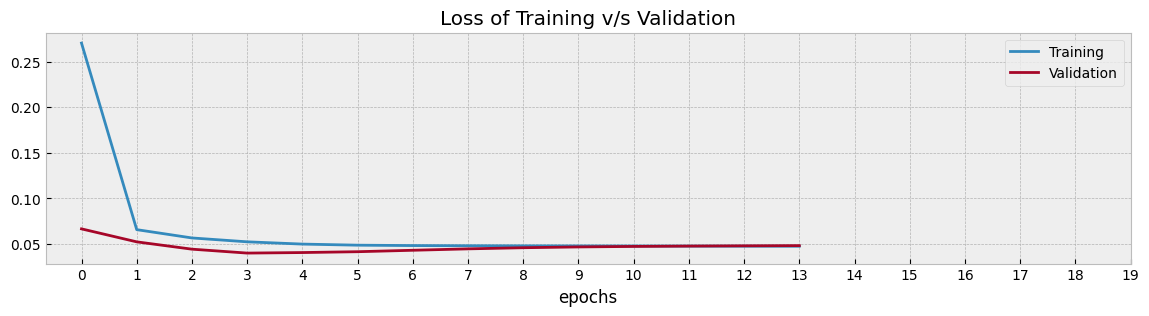

In [46]:
plt.figure(figsize = (14,3))
plt.plot(history.history['loss'] , label = 'Training')
plt.plot(history.history['val_loss'] , label = 'Validation')
plt.title('Loss of Training v/s Validation') 
plt.legend() 
plt.xticks(range(20)), plt.xlabel('epochs')  
plt.show()

Mean Square Error in Training v/s Validation

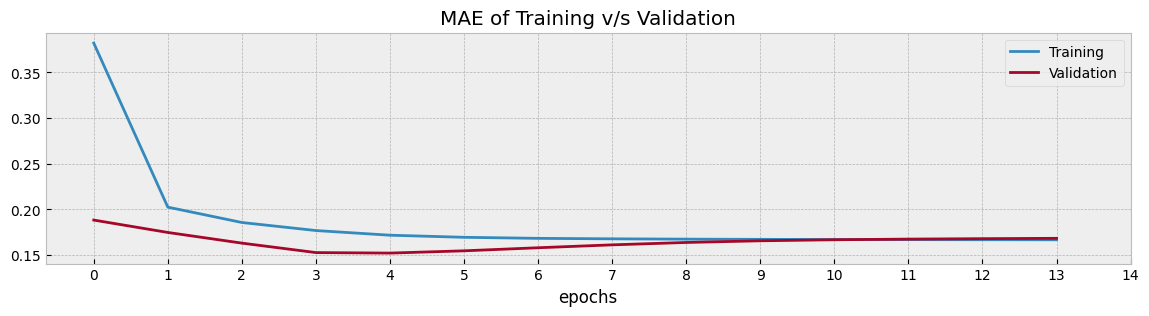

In [47]:
plt.figure(figsize = (14,3))
plt.plot(history.history['mae'] , label = 'Training')
plt.plot(history.history['val_mae'] , label = 'Validation')
plt.title('MAE of Training v/s Validation')
plt.legend() , plt.xticks(range(15)) , plt.xlabel('epochs') 
plt.show()

### Visulation and Plotting of Prediction v/s Real

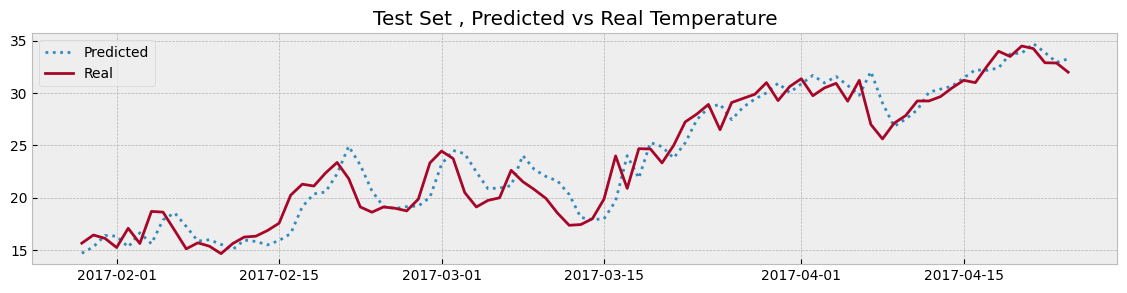

In [48]:
plt.figure(figsize = (14,3))
plt.plot(test.index[seq:], y_pred_original_rnn , linestyle = ':' , label = 'Predicted')
plt.plot(test.index[seq:] ,y_true_original_rnn  , label = 'Real')
plt.legend()
plt.title('Test Set , Predicted vs Real Temperature')
plt.show()

## LSTM (Long Short Term Memory)

In [49]:
tf.random.set_seed(42)
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (seq , 4)) ,
    tf.keras.layers.LSTM(32 , activation = 'sigmoid'),
    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02) , 
              loss = tf.keras.losses.MeanSquaredError() , 
              metrics = ['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss' , 
                                                  patience=10 , restore_best_weights=True)

In [50]:
history = model_lstm.fit(x = ds_train, y = target_train , validation_data=(ds_val , target_val),
                        epochs=100 , batch_size = 32 , callbacks=[early_stopping])

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.5182 - mae: 0.5491 - val_loss: 0.0589 - val_mae: 0.1818
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0654 - mae: 0.1982 - val_loss: 0.0540 - val_mae: 0.1760
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0548 - mae: 0.1802 - val_loss: 0.0468 - val_mae: 0.1654
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0501 - mae: 0.1716 - val_loss: 0.0427 - val_mae: 0.1593
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0473 - mae: 0.1654 - val_loss: 0.0406 - val_mae: 0.1555
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 - mae: 0.1617 - val_loss: 0.0407 - val_mae: 0.1555
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0447 - mae: 0.1599 - val_loss: 0.0422 - val_mae: 0.1576
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0441 - mae: 0.1584 - val_loss: 0.0431 - val_mae: 0.1590
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.04

In [51]:
val_loss , val_mae = model_lstm.evaluate(ds_val , target_val)
print(f'validation loss : {val_loss:0.2f} ')
print(f'validation mean absolute error : {(val_mae):0.3f} ')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0463 - mae: 0.1690 
validation loss : 0.04 
validation mean absolute error : 0.155 


### Metric Evaluation

Metric on Validation Set

In [52]:
y_pred = model_lstm.predict(ds_val)
y_true_original_lstm , y_pred_original_lstm = inverse_transform(target_val , y_pred , scaler)
metrics(y_true_original_lstm , y_pred_original_lstm , 'lstm val')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


{'model': 'lstm val', 'mae': '1.16', 'mape': '4.71%', 'r2': '92.77%'}

Metric on Test Set

In [53]:
y_pred = model_lstm.predict(ds_test)
y_true_original_lstm , y_pred_original_lstm = inverse_transform(target_test , y_pred , scaler)
score_lstm = metrics(y_true_original_lstm , y_pred_original_lstm , 'LSTM')
score_lstm

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


{'model': 'LSTM', 'mae': '1.47', 'mape': '6.76%', 'r2': '90.73%'}

In [54]:
model_performance.append(score_lstm)

### Losses and Mean Square Error over Epochs

Losses in Epochs in Training v/s Validation

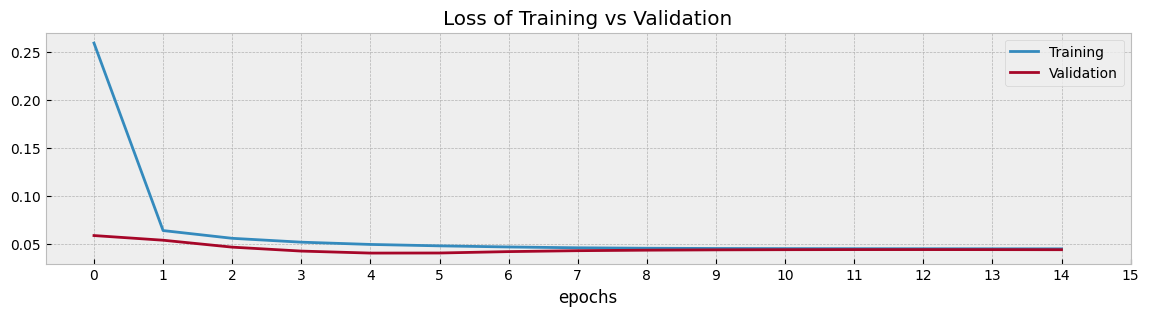

In [55]:
plt.figure(figsize = (14,3))
plt.plot(history.history['loss'] , label = 'Training')
plt.plot(history.history['val_loss'] , label = 'Validation')
plt.title('Loss of Training vs Validation') 
plt.legend() 
plt.xticks(range(16)) , plt.xlabel('epochs') 
plt.show()

Mean Square Error in Training v/s Validation

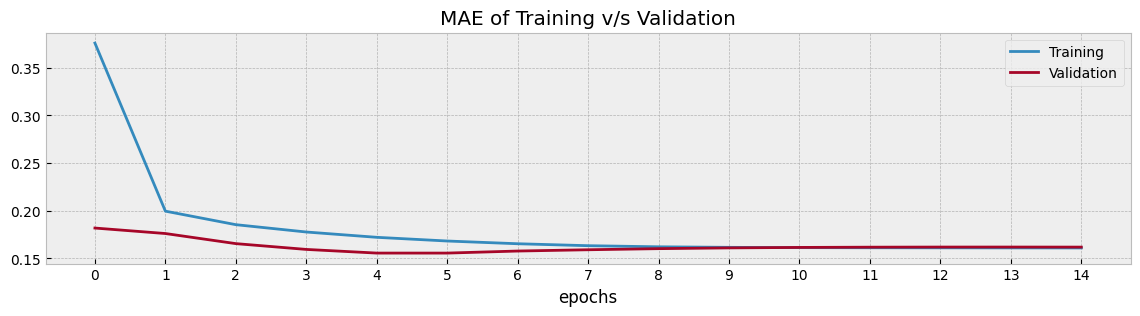

In [56]:
plt.figure(figsize = (14,3))
plt.plot(history.history['mae'] , label = 'Training')
plt.plot(history.history['val_mae'] , label = 'Validation')
plt.title('MAE of Training v/s Validation')
plt.legend() , plt.xticks(range(15)) , plt.xlabel('epochs') 
plt.show()

### Visulation and Plotting of Prediction v/s Real

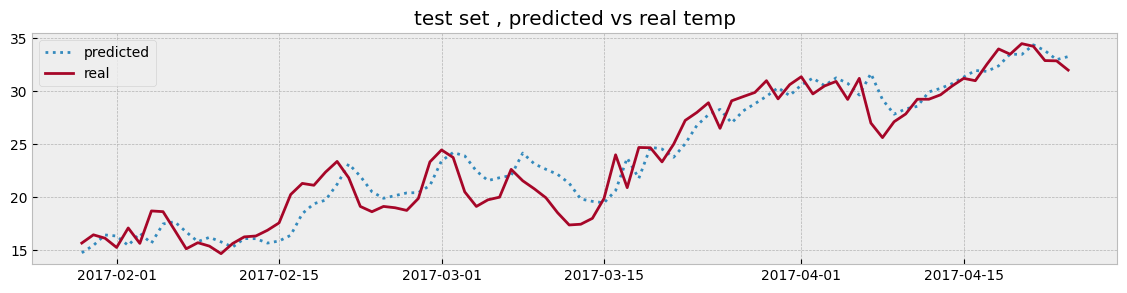

In [57]:
plt.figure(figsize = (14,3))
plt.plot(test.index[seq:], y_pred_original_lstm , linestyle = ':' , label = 'predicted')
plt.plot(test.index[seq:] ,y_true_original_lstm  , label = 'real')
plt.legend()
plt.title('test set , predicted vs real temp')
plt.show()

## ARIMA

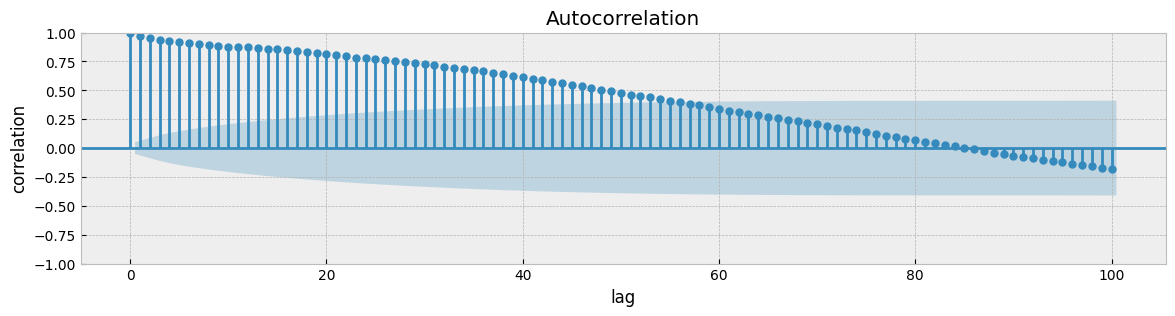

(Text(0.5, 28.0, 'lag'), Text(28.0, 0.5, 'correlation'), None)

In [58]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
fig , ax = plt.subplots(figsize = (14,3))
plot_acf(x = df_train['temp'] , ax = ax , lags=100)
plt.xlabel('lag') , plt.ylabel('correlation') , plt.show()

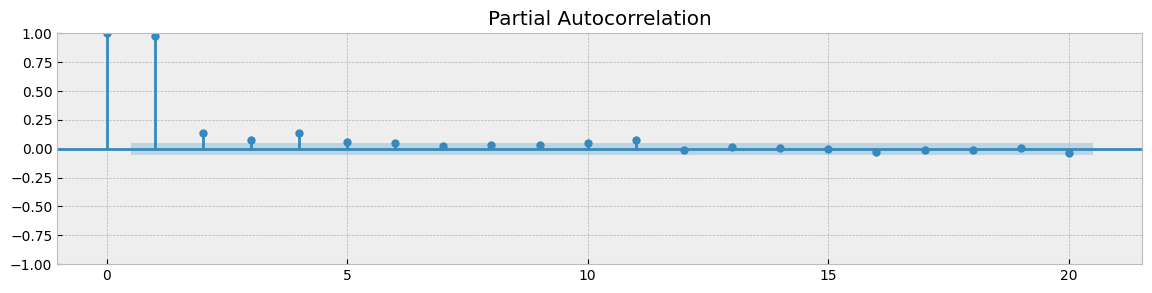

In [59]:
fig , ax = plt.subplots(figsize = (14,3))
plot_pacf(x = df_train['temp'] , ax = ax , lags=20)
plt.show()

In [60]:
from statsmodels.tsa.stattools import pacf , acf
acf = acf(x = df_weekly['temp'] , nlags = 20)
pacf = pacf(x = df_weekly['temp'] , nlags=20)

In [61]:
from statsmodels.tsa.arima.model import ARIMA
origin , start , end = '2013' , '2017-01-01' , '2017-04-24'
test_period = pd.date_range(start , end)
y_preds = []
for today in test_period.shift(-1):
    model_arima = ARIMA(df_all[origin : today]['temp'].asfreq('D'),
                   order = (1,1,1) , 
                   seasonal_order=(1,1,1,7))
    model_arima = model_arima.fit()
    y_pred = model_arima.forecast().iloc[0]
    y_preds.append(y_pred)

In [62]:
y_preds = pd.Series(y_preds , index = test_period)
y_true = df_all['temp'].loc[test_period]

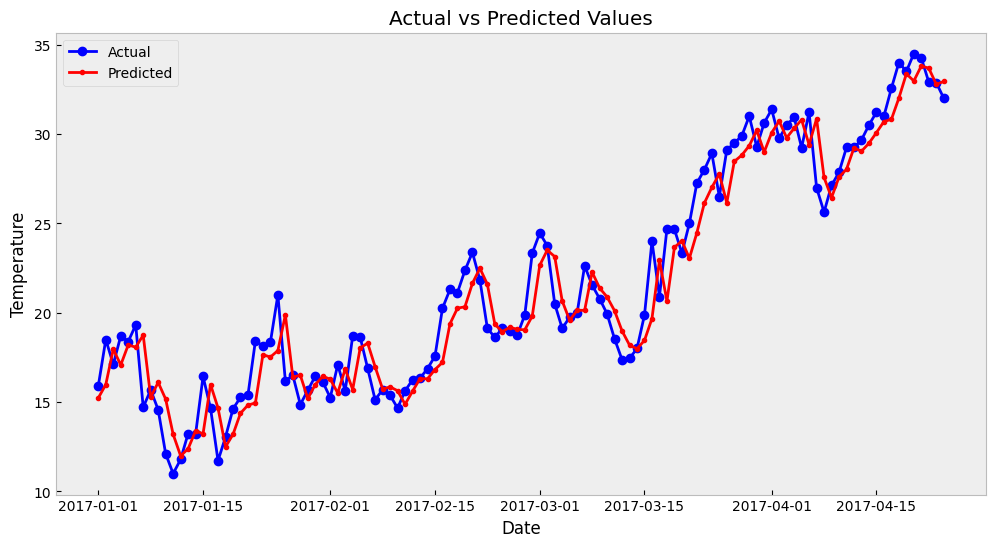

In [63]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual', color='blue', marker='o')
plt.plot(y_preds, label='Predicted', color='red', marker='.')

# Adding title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid()

# Display the plot
plt.show()

In [64]:
score_arima = metrics(y_true , y_preds , model = 'ARIMA')
score_arima

{'model': 'ARIMA', 'mae': '1.33', 'mape': '6.65%', 'r2': '92.92%'}

In [65]:
model_performance.append(score_arima)

# Models Comparision

In [66]:
model_performance

[{'model': 'Naive', 'mae': '2.56', 'mape': '11.12%', 'r2': '80.45%'},
 {'model': 'RNN', 'mae': '1.41', 'mape': '6.45%', 'r2': '90.84%'},
 {'model': 'LSTM', 'mae': '1.47', 'mape': '6.76%', 'r2': '90.73%'},
 {'model': 'ARIMA', 'mae': '1.33', 'mape': '6.65%', 'r2': '92.92%'}]

In [67]:
df_performance = pd.DataFrame(model_performance)
df_performance['mae'] = df_performance['mae'].astype(float)
df_performance['mape'] = df_performance['mape'].str.replace('%', '').astype(float)
df_performance['r2'] = df_performance['r2'].str.replace('%', '').astype(float)
df_performance

,model,mae,mape,r2
0,Naive,2.56,11.12,80.45
1,RNN,1.41,6.45,90.84
2,LSTM,1.47,6.76,90.73
3,ARIMA,1.33,6.65,92.92


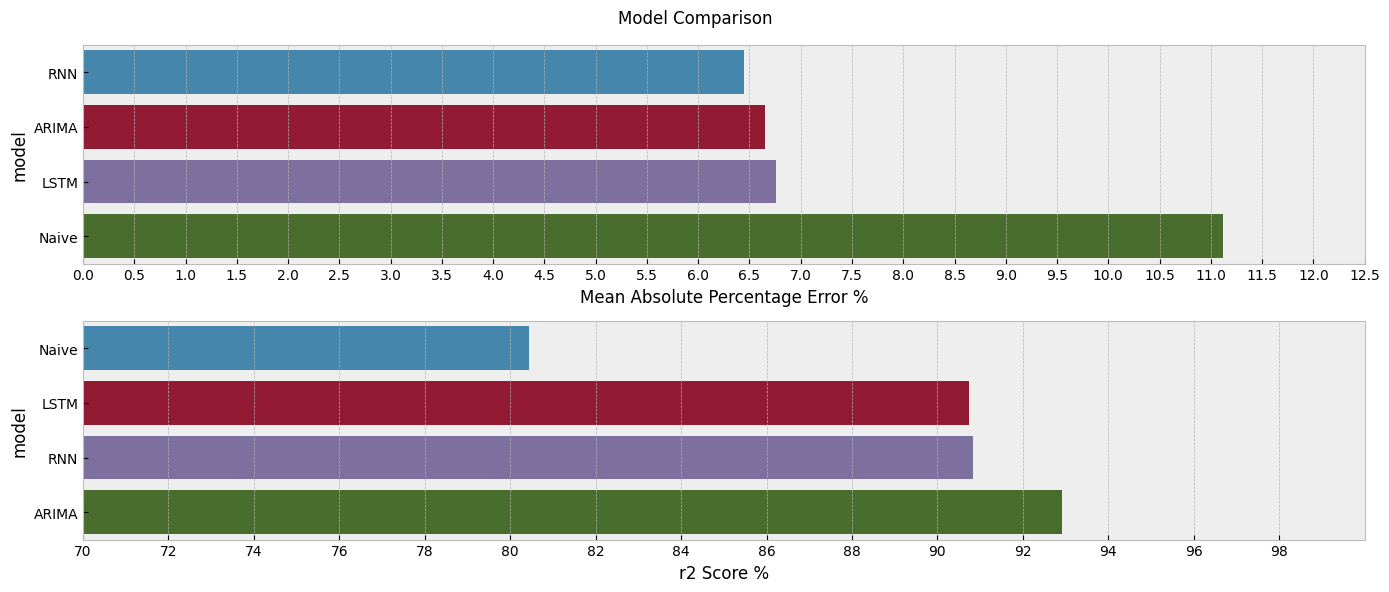

In [68]:
fig , ax = plt.subplots(2,1,figsize=(14,6))
sns.barplot(df_performance.sort_values(by = 'mape') ,x ='mape' ,y = 'model' , ax = ax[0])
sns.barplot(df_performance.sort_values(by = 'r2') ,x ='r2' ,y = 'model' , ax = ax[1])
ax[0].set_xlabel('Mean Absolute Percentage Error %' ) , ax[0].set_xticks(np.arange(0,13,0.5))
ax[1].set_xlabel('r2 Score %') , ax[1].set_xticks(np.arange(50,100,2)) , ax[1].set_xlim(70,100)
plt.suptitle('Model Comparison')
plt.tight_layout()
plt.show()